In [0]:
# !pip install tensorflow-gpu==2.0.0-beta1
# !pip install 'tensorflow-hub == 0.5'


In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [0]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)


In [0]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [0]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [17]:
print(' training :', count(train_dir))
print('validation :', count(validation_dir))


 training : /root/.keras/datasets/PlantVillage/train : 43444files
validation : /root/.keras/datasets/PlantVillage/validation : 10861files


In [18]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
5f4bc7eab949d289f25ac40731be00ee1485a9f0
replace Plant-Diseases-Detector-master/GreenDoctor/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/Project.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/codeStyleConfig.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detector-master/GreenDoctor/.idea/encodings.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detector-master/GreenDoctor/.idea/gradle.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detector-master/GreenDoctor/.idea/misc.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detector-master/GreenDoctor/.idea/runConfigurations.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detector-master/GreenDoctor/app/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Plant-Diseases-Detecto

In [19]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
print ('classes are')  
print (classes)

classes are
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato

In [20]:
print('Number of classes:',len(classes))

Number of classes: 38


In [0]:


IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

In [22]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [24]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

W0724 19:21:44.362852 139635632998272 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
LEARNING_RATE = 0.0001 #@param {type:"number"}
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



In [27]:

EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/5
678/678 [==============================] - 612s 902ms/step - loss: 1.5359 - acc: 0.4322 - val_loss: 0.5772 - val_acc: 0.8411
Epoch 2/5
678/678 [==============================] - 602s 888ms/step - loss: 0.7067 - acc: 0.7718 - val_loss: 0.3978 - val_acc: 0.8800
Epoch 3/5
678/678 [==============================] - 602s 888ms/step - loss: 0.5613 - acc: 0.8208 - val_loss: 0.3132 - val_acc: 0.9044
Epoch 4/5
678/678 [==============================] - 599s 884ms/step - loss: 0.4885 - acc: 0.8444 - val_loss: 0.2804 - val_acc: 0.9121
Epoch 5/5
678/678 [==============================] - 597s 880ms/step - loss: 0.4442 - acc: 0.8569 - val_loss: 0.2521 - val_acc: 0.9213


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  655872    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  19494     
Total params: 2,933,350
Trainable params: 675,366
Non-trainable params: 2,257,984
_________________________________________________________________


range(0, 5)


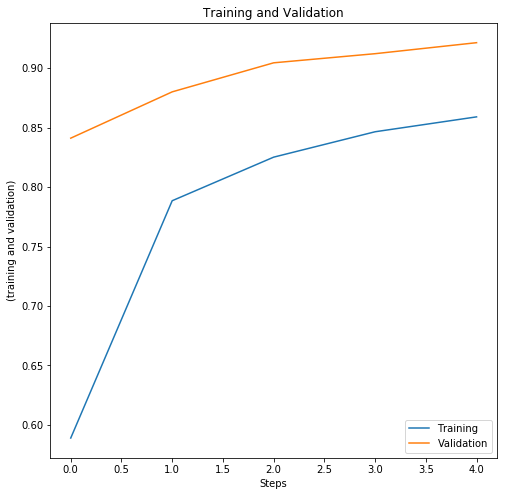

In [29]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
print(epochs_range)

plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation') 
plt.ylabel("(training and validation)")
plt.xlabel("Steps")

plt.show()

In [0]:

import cv2
import itertools
import random
from collections import Counter
from glob import iglob
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    return img
def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

Source class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), obtained from Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/e7ba72e2-a8ec-4376-a053-d33c1ba0a819___FAM_L.Blight 4781.JPG


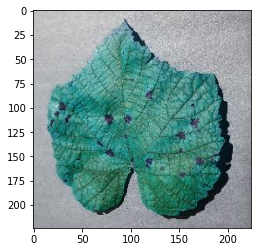

<Figure size 432x288 with 0 Axes>

estimated output Grape___Leaf_blight_(Isariopsis_Leaf_Spot), accuracy of outcome 0.770432
Source class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), obtained from Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/fb12efe4-4fe8-42e3-bd92-27cbd29497a0___FAM_L.Blight 4567.JPG


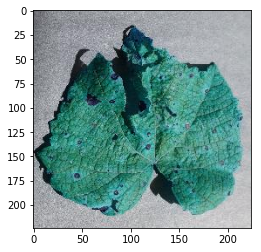

estimated output Grape___Leaf_blight_(Isariopsis_Leaf_Spot), accuracy of outcome 0.785170
Source class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, obtained from Tomato___Tomato_Yellow_Leaf_Curl_Virus/f88f2b25-3713-4271-98cd-24c062130f74___YLCV_NREC 0055.JPG


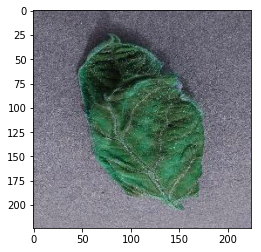

<Figure size 432x288 with 0 Axes>

estimated output Tomato___Tomato_Yellow_Leaf_Curl_Virus, accuracy of outcome 0.999178
Source class: Tomato___healthy, obtained from Tomato___healthy/902d49e5-febf-4970-b0fb-99a57e8e284b___GH_HL Leaf 179.JPG


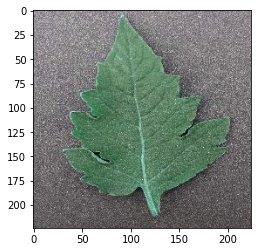

<Figure size 432x288 with 0 Axes>

estimated output Tomato___healthy, accuracy of outcome 0.925174
Source class: Corn_(maize)___Common_rust_, obtained from Corn_(maize)___Common_rust_/RS_Rust 1743.JPG


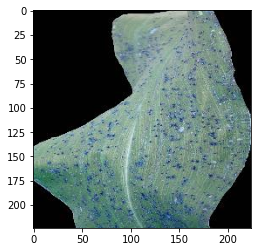

<Figure size 432x288 with 0 Axes>

estimated output Corn_(maize)___Common_rust_, accuracy of outcome 0.934408


In [31]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("Source class: %s, obtained from %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()
    print("estimated output %s, accuracy of outcome %f" % (list(prediction.keys())[0], list(prediction.values())[0]))